In [1]:
# import libraries
import pandas as pd
import numpy as np
import torch
from torch import optim
import torch.nn as nn
from torch.nn import Conv2d, MaxPool2d, Linear, Dropout, BatchNorm2d, ReLU, Sequential, Module, Softmax
import torch.nn.functional as F
!pip install blitz-bayesian-pytorch
from blitz.modules import BayesianLinear, BayesianConv2d
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

import time
import matplotlib.pyplot as plt

from KlLayers import KlLayers

# set seed
torch.manual_seed(0)

ModuleNotFoundError: No module named 'KlLayers'

In [2]:
# set cuda to cpu if no gpu available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# load data
df = pd.read_csv('/Users/kristian/Documents/Skole/9. Semester/Thesis Preparation/Code/BNNs/Data/quality_of_food.csv')
print(df.head())

# convert 'savings' column to numeric
df['savings'] = np.where(df['savings'] == 'low', 0, np.where(df['savings'] == 'medium', 1, 2))

# split data into train and test
train, test = train_test_split(df, test_size=0.2, random_state=0)

# split the data into X and y
X_train = train.drop(columns=['target'])
y_train = train['target']
X_test = test.drop(columns=['target'])
y_test = test['target']

# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))


# convert data to tensors
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

   target  monthly_income  time_of_month savings  guests
0       1            3915             21  medium       0
1       2            3254             10    high       0
2       3            5079             12  medium       0
3       1            4046              4  medium       0
4       5            8286              2  medium       0


In [6]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        #self.linear = nn.Linear(input_dim, output_dim)
        self.blinear1 = BayesianLinear(4, 10)
        self.blinear2 = BayesianLinear(10, output_dim)
        
    def forward(self, x):
        x_ = self.blinear1(x)
        x_ = F.relu(x_)
        return self.blinear2(x_)

In [7]:
def evaluate_regression(regressor,
                        X,
                        y,
                        samples = 100,
                        std_multiplier = 2):
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    ic_acc = (ci_lower <= y) * (ci_upper >= y)
    ic_acc = ic_acc.float().mean()

    # rmse
    rmse = torch.sqrt(torch.mean((means - y)**2))

    # mae
    mae = torch.mean(torch.abs(means - y))

    # mse
    mse = torch.mean((means - y)**2)

    return ic_acc, (ci_upper >= y).float().mean(), (ci_lower <= y).float().mean(), rmse, mae, mse

In [8]:
regressor = BayesianRegressor(input_dim= 4, output_dim= 5)

# define optimizer
optimizer = optim.Adam(regressor.parameters(), lr=0.01)  # only works with cuda
criterion = torch.nn.MSELoss()

ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=16, shuffle=True)

In [9]:
iteration = 0
stored_accuracies = []

# start timer
start = time.time()

for epoch in range(100):
    for i, (datapoints, labels) in enumerate(dataloader_train):

        optimizer.zero_grad()
        
        loss = regressor.sample_elbo(inputs=datapoints,
                           labels=labels,
                           criterion=criterion,
                           sample_nbr=6)
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%100==0:
            ic_acc, under_ci_upper, over_ci_lower, rmse, mae, mse = evaluate_regression(regressor,
                                                                        X_test,
                                                                        y_test,
                                                                        samples=25,
                                                                        std_multiplier=3)
            stored_accuracies.append([ic_acc, under_ci_upper, over_ci_lower, loss])
            
            print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}, RMSE: {:.2f}, MSE: {:.2f}, MAE: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower, rmse, mse, mae))
            print("Loss: {:.4f}".format(loss))
            print("Time elapsed: {:.2f} seconds".format(time.time() - start))

/Users/kristian/.local/share/virtualenvs/DataViz-TTGQRQcT/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


CI acc: 0.32, CI upper acc: 0.70, CI lower acc: 0.62, RMSE: 1.06, MSE: 1.13, MAE: 0.83
Loss: 416.6193
Time elapsed: 2.76 seconds
CI acc: 0.19, CI upper acc: 0.70, CI lower acc: 0.49, RMSE: 1.06, MSE: 1.13, MAE: 0.83
Loss: 391.3026
Time elapsed: 4.42 seconds
CI acc: 0.19, CI upper acc: 0.70, CI lower acc: 0.49, RMSE: 1.06, MSE: 1.13, MAE: 0.83
Loss: 360.1765
Time elapsed: 6.31 seconds
CI acc: 0.32, CI upper acc: 0.70, CI lower acc: 0.62, RMSE: 1.06, MSE: 1.13, MAE: 0.83
Loss: 334.2808
Time elapsed: 8.20 seconds
CI acc: 0.32, CI upper acc: 0.70, CI lower acc: 0.62, RMSE: 1.06, MSE: 1.13, MAE: 0.83
Loss: 304.9693
Time elapsed: 10.03 seconds
CI acc: 0.32, CI upper acc: 0.70, CI lower acc: 0.62, RMSE: 1.06, MSE: 1.13, MAE: 0.83
Loss: 279.3372
Time elapsed: 11.96 seconds
CI acc: 0.32, CI upper acc: 0.70, CI lower acc: 0.62, RMSE: 1.06, MSE: 1.13, MAE: 0.83
Loss: 256.5169
Time elapsed: 13.90 seconds
CI acc: 0.32, CI upper acc: 0.70, CI lower acc: 0.62, RMSE: 1.06, MSE: 1.13, MAE: 0.83
Loss: 2

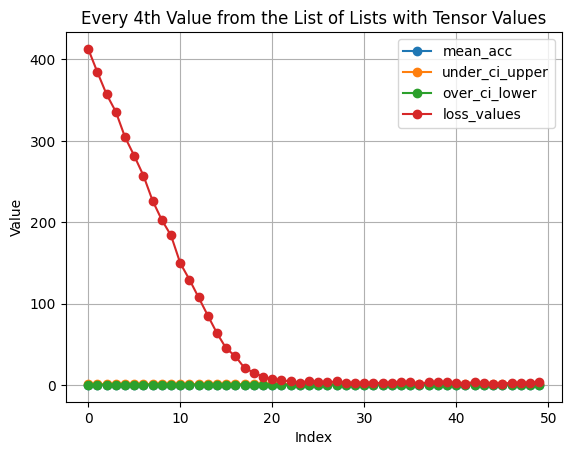

In [59]:
mean_acc= [sublist[0].item() for sublist in stored_accuracies]
under_ci_upper= [sublist[1].item() for sublist in stored_accuracies]
over_ci_lower= [sublist[2].item() for sublist in stored_accuracies]
loss_values= [sublist[3].item() for sublist in stored_accuracies]

# Create x-axis values (index of the sublist)
x_values = range(len(loss_values))

# plot all accuracies in one plot
plt.plot(x_values, mean_acc, marker='o', linestyle='-', label='mean_acc')
plt.plot(x_values, under_ci_upper, marker='o', linestyle='-', label='under_ci_upper')
plt.plot(x_values, over_ci_lower, marker='o', linestyle='-', label='over_ci_lower')
plt.plot(x_values, loss_values, marker='o', linestyle='-', label='loss_values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Every 4th Value from the List of Lists with Tensor Values')
plt.grid(True)
plt.legend()
plt.show()


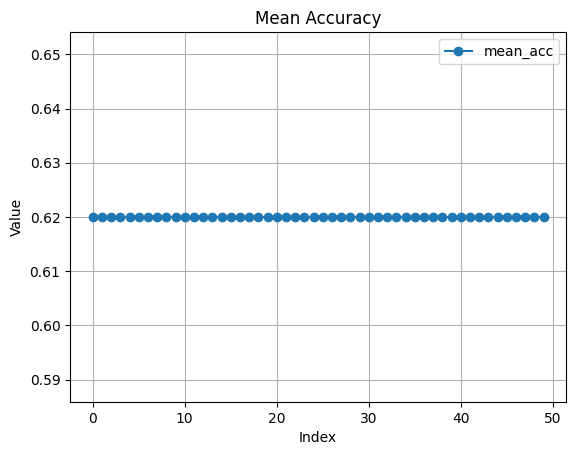

In [36]:
# plot mean accuracy
plt.plot(x_values, over_ci_lower, marker='o', linestyle='-', label='mean_acc')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Mean Accuracy')
plt.grid(True)
plt.legend()
plt.show()
